In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import torch
import torch.nn as nn

# Any results you write to the current directory are saved as output.
print(torch)
#!python -W ignore::DeprecationWarning

['object', 'yolov3weights', 'iwildcam-2019-fgvc6', 'cars-yolo']
<module 'torch' from '/opt/conda/lib/python3.6/site-packages/torch/__init__.py'>


In [2]:
import warnings  
warnings.filterwarnings('ignore')

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
!ls ../input/yolov3weights

yolov3.weights


In [5]:
#models = '../input/object/models.py'

In [6]:
# %load '../input/object/parse_config.py'


def parse_model_config(path):
    """Parses the yolo-v3 layer configuration file and returns module definitions"""
    file = open(path, 'r')
    lines = file.read().split('\n')
    lines = [x for x in lines if x and not x.startswith('#')]
    lines = [x.rstrip().lstrip() for x in lines] # get rid of fringe whitespaces
    module_defs = []
    for line in lines:
        if line.startswith('['): # This marks the start of a new block
            module_defs.append({})
            module_defs[-1]['type'] = line[1:-1].rstrip()
            if module_defs[-1]['type'] == 'convolutional':
                module_defs[-1]['batch_normalize'] = 0
        else:
            key, value = line.split("=")
            value = value.strip()
            module_defs[-1][key.rstrip()] = value.strip()

    return module_defs

def parse_data_config(path):
    """Parses the data configuration file"""
    options = dict()
    options['gpus'] = '0,1,2,3'
    options['num_workers'] = '10'
    with open(path, 'r') as fp:
        lines = fp.readlines()
    for line in lines:
        line = line.strip()
        if line == '' or line.startswith('#'):
            continue
        key, value = line.split('=')
        options[key.strip()] = value.strip()
    return options


In [7]:
# %load '../input/object/utils.py'
from __future__ import division
import math
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

#import matplotlib.pyplot as plt
#import matplotlib.patches as patches


def load_classes(path):
    """
    Loads class labels at 'path'
    """
    fp = open(path, "r")
    names = fp.read().split("\n")[:-1]
    return names


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.

    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou


def bbox_iou_numpy(box1, box2):
    """Computes IoU between bounding boxes.
    Parameters
    ----------
    box1 : ndarray
        (N, 4) shaped array with bboxes
    box2 : ndarray
        (M, 4) shaped array with bboxes
    Returns
    -------
    : ndarray
        (N, M) shaped array with IoUs
    """
    area = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

    iw = np.minimum(np.expand_dims(box1[:, 2], axis=1), box2[:, 2]) - np.maximum(
        np.expand_dims(box1[:, 0], 1), box2[:, 0]
    )
    ih = np.minimum(np.expand_dims(box1[:, 3], axis=1), box2[:, 3]) - np.maximum(
        np.expand_dims(box1[:, 1], 1), box2[:, 1]
    )

    iw = np.maximum(iw, 0)
    ih = np.maximum(ih, 0)

    ua = np.expand_dims((box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1]), axis=1) + area - iw * ih

    ua = np.maximum(ua, np.finfo(float).eps)

    intersection = iw * ih

    return intersection / ua


def non_max_suppression(prediction, num_classes, conf_thres=0.5, nms_thres=0.4):
    """
    Removes detections with lower object confidence score than 'conf_thres' and performs
    Non-Maximum Suppression to further filter detections.
    Returns detections with shape:
        (x1, y1, x2, y2, object_conf, class_score, class_pred)
    """

    # From (center x, center y, width, height) to (x1, y1, x2, y2)
    box_corner = prediction.new(prediction.shape)
    box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
    box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
    box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
    box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
    prediction[:, :, :4] = box_corner[:, :, :4]

    output = [None for _ in range(len(prediction))]
    for image_i, image_pred in enumerate(prediction):
        # Filter out confidence scores below threshold
        conf_mask = (image_pred[:, 4] >= conf_thres).squeeze()
        image_pred = image_pred[conf_mask]
        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Get score and class with highest confidence
        class_conf, class_pred = torch.max(image_pred[:, 5 : 5 + num_classes], 1, keepdim=True)
        # Detections ordered as (x1, y1, x2, y2, obj_conf, class_conf, class_pred)
        detections = torch.cat((image_pred[:, :5], class_conf.float(), class_pred.float()), 1)
        # Iterate through all predicted classes
        unique_labels = detections[:, -1].cpu().unique()
        if prediction.is_cuda:
            unique_labels = unique_labels.cuda()
        for c in unique_labels:
            # Get the detections with the particular class
            detections_class = detections[detections[:, -1] == c]
            # Sort the detections by maximum objectness confidence
            _, conf_sort_index = torch.sort(detections_class[:, 4], descending=True)
            detections_class = detections_class[conf_sort_index]
            # Perform non-maximum suppression
            max_detections = []
            while detections_class.size(0):
                # Get detection with highest confidence and save as max detection
                max_detections.append(detections_class[0].unsqueeze(0))
                # Stop if we're at the last detection
                if len(detections_class) == 1:
                    break
                # Get the IOUs for all boxes with lower confidence
                ious = bbox_iou(max_detections[-1], detections_class[1:])
                # Remove detections with IoU >= NMS threshold
                detections_class = detections_class[1:][ious < nms_thres]

            max_detections = torch.cat(max_detections).data
            # Add max detections to outputs
            output[image_i] = (
                max_detections if output[image_i] is None else torch.cat((output[image_i], max_detections))
            )

    return output


def build_targets(
    pred_boxes, pred_conf, pred_cls, target, anchors, num_anchors, num_classes, grid_size, ignore_thres, img_dim
):
    nB = target.size(0)
    nA = num_anchors
    nC = num_classes
    nG = grid_size
    mask = torch.zeros(nB, nA, nG, nG)
    conf_mask = torch.ones(nB, nA, nG, nG)
    tx = torch.zeros(nB, nA, nG, nG)
    ty = torch.zeros(nB, nA, nG, nG)
    tw = torch.zeros(nB, nA, nG, nG)
    th = torch.zeros(nB, nA, nG, nG)
    tconf = torch.ByteTensor(nB, nA, nG, nG).fill_(0)
    tcls = torch.ByteTensor(nB, nA, nG, nG, nC).fill_(0)

    nGT = 0
    nCorrect = 0
    for b in range(nB):
        for t in range(target.shape[1]):
            if target[b, t].sum() == 0:
                continue
            nGT += 1
            # Convert to position relative to box
            gx = target[b, t, 1] * nG
            gy = target[b, t, 2] * nG
            gw = target[b, t, 3] * nG
            gh = target[b, t, 4] * nG
            # Get grid box indices
            gi = int(gx)
            gj = int(gy)
            # Get shape of gt box
            gt_box = torch.FloatTensor(np.array([0, 0, gw, gh])).unsqueeze(0)
            # Get shape of anchor box
            anchor_shapes = torch.FloatTensor(np.concatenate((np.zeros((len(anchors), 2)), np.array(anchors)), 1))
            # Calculate iou between gt and anchor shapes
            anch_ious = bbox_iou(gt_box, anchor_shapes)
            # Where the overlap is larger than threshold set mask to zero (ignore)
            conf_mask[b, anch_ious > ignore_thres, gj, gi] = 0
            # Find the best matching anchor box
            best_n = np.argmax(anch_ious)
            # Get ground truth box
            gt_box = torch.FloatTensor(np.array([gx, gy, gw, gh])).unsqueeze(0)
            # Get the best prediction
            pred_box = pred_boxes[b, best_n, gj, gi].unsqueeze(0)
            # Masks
            mask[b, best_n, gj, gi] = 1
            conf_mask[b, best_n, gj, gi] = 1
            # Coordinates
            tx[b, best_n, gj, gi] = gx - gi
            ty[b, best_n, gj, gi] = gy - gj
            # Width and height
            tw[b, best_n, gj, gi] = math.log(gw / anchors[best_n][0] + 1e-16)
            th[b, best_n, gj, gi] = math.log(gh / anchors[best_n][1] + 1e-16)
            # One-hot encoding of label
            target_label = int(target[b, t, 0])
            tcls[b, best_n, gj, gi, target_label] = 1
            tconf[b, best_n, gj, gi] = 1

            # Calculate iou between ground truth and best matching prediction
            iou = bbox_iou(gt_box, pred_box, x1y1x2y2=False)
            pred_label = torch.argmax(pred_cls[b, best_n, gj, gi])
            score = pred_conf[b, best_n, gj, gi]
            if iou > 0.5 and pred_label == target_label and score > 0.5:
                nCorrect += 1

    return nGT, nCorrect, mask, conf_mask, tx, ty, tw, th, tconf, tcls


def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return torch.from_numpy(np.eye(num_classes, dtype="uint8")[y])


In [8]:
class Upsample(nn.Module):
    def __init__(self,  scale_factor, mode):
        super(Upsample, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode
    def forward(self, x):
        return F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)

In [9]:
# %load '../input/object/models.py'
from __future__ import division

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

from PIL import Image

#from utils.parse_config import *
#from utils.utils import build_targets
from collections import defaultdict

##import matplotlib.pyplot as plt
##import matplotlib.patches as patches


def create_modules(module_defs):
    """
    Constructs module list of layer blocks from module configuration in module_defs
    """
    hyperparams = module_defs.pop(0)
    output_filters = [int(hyperparams["channels"])]
    module_list = nn.ModuleList()
    for i, module_def in enumerate(module_defs):
        modules = nn.Sequential()

        if module_def["type"] == "convolutional":
            bn = int(module_def["batch_normalize"])
            filters = int(module_def["filters"])
            kernel_size = int(module_def["size"])
            pad = (kernel_size - 1) // 2 if int(module_def["pad"]) else 0
            modules.add_module(
                "conv_%d" % i,
                nn.Conv2d(
                    in_channels=output_filters[-1],
                    out_channels=filters,
                    kernel_size=kernel_size,
                    stride=int(module_def["stride"]),
                    padding=pad,
                    bias=not bn,
                ),
            )
            if bn:
                modules.add_module("batch_norm_%d" % i, nn.BatchNorm2d(filters))
            if module_def["activation"] == "leaky":
                modules.add_module("leaky_%d" % i, nn.LeakyReLU(0.1))

        elif module_def["type"] == "maxpool":
            kernel_size = int(module_def["size"])
            stride = int(module_def["stride"])
            if kernel_size == 2 and stride == 1:
                padding = nn.ZeroPad2d((0, 1, 0, 1))
                modules.add_module("_debug_padding_%d" % i, padding)
            maxpool = nn.MaxPool2d(
                kernel_size=int(module_def["size"]),
                stride=int(module_def["stride"]),
                padding=int((kernel_size - 1) // 2),
            )
            modules.add_module("maxpool_%d" % i, maxpool)

        elif module_def["type"] == "upsample":
            upsample = Upsample(scale_factor=int(module_def["stride"]), mode="nearest")
            modules.add_module("upsample_%d" % i, upsample)

        elif module_def["type"] == "route":
            layers = [int(x) for x in module_def["layers"].split(",")]
            filters = sum([output_filters[layer_i] for layer_i in layers])
            modules.add_module("route_%d" % i, EmptyLayer())

        elif module_def["type"] == "shortcut":
            filters = output_filters[int(module_def["from"])]
            modules.add_module("shortcut_%d" % i, EmptyLayer())

        elif module_def["type"] == "yolo":
            anchor_idxs = [int(x) for x in module_def["mask"].split(",")]
            # Extract anchors
            anchors = [int(x) for x in module_def["anchors"].split(",")]
            anchors = [(anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]
            anchors = [anchors[i] for i in anchor_idxs]
            num_classes = int(module_def["classes"])
            img_height = int(hyperparams["height"])
            # Define detection layer
            yolo_layer = YOLOLayer(anchors, num_classes, img_height)
            modules.add_module("yolo_%d" % i, yolo_layer)
        # Register module list and number of output filters
        module_list.append(modules)
        output_filters.append(filters)

    return hyperparams, module_list


class EmptyLayer(nn.Module):
    """Placeholder for 'route' and 'shortcut' layers"""

    def __init__(self):
        super(EmptyLayer, self).__init__()


class YOLOLayer(nn.Module):
    """Detection layer"""

    def __init__(self, anchors, num_classes, img_dim):
        super(YOLOLayer, self).__init__()
        self.anchors = anchors
        self.num_anchors = len(anchors)
        self.num_classes = num_classes
        self.bbox_attrs = 5 + num_classes
        self.image_dim = img_dim
        self.ignore_thres = 0.5
        self.lambda_coord = 1

        self.mse_loss = nn.MSELoss(reduction=True)  # Coordinate loss
        self.bce_loss = nn.BCELoss(reduction=True)  # Confidence loss
        self.ce_loss = nn.CrossEntropyLoss()  # Class loss

    def forward(self, x, targets=None):
        nA = self.num_anchors
        nB = x.size(0)
        nG = x.size(2)
        stride = self.image_dim / nG

        # Tensors for cuda support
        FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
        LongTensor = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor
        ByteTensor = torch.cuda.ByteTensor if x.is_cuda else torch.ByteTensor

        prediction = x.view(nB, nA, self.bbox_attrs, nG, nG).permute(0, 1, 3, 4, 2).contiguous()

        # Get outputs
        x = torch.sigmoid(prediction[..., 0])  # Center x
        y = torch.sigmoid(prediction[..., 1])  # Center y
        w = prediction[..., 2]  # Width
        h = prediction[..., 3]  # Height
        pred_conf = torch.sigmoid(prediction[..., 4])  # Conf
        pred_cls = torch.sigmoid(prediction[..., 5:])  # Cls pred.

        # Calculate offsets for each grid
        grid_x = torch.arange(nG).repeat(nG, 1).view([1, 1, nG, nG]).type(FloatTensor)
        grid_y = torch.arange(nG).repeat(nG, 1).t().view([1, 1, nG, nG]).type(FloatTensor)
        scaled_anchors = FloatTensor([(a_w / stride, a_h / stride) for a_w, a_h in self.anchors])
        anchor_w = scaled_anchors[:, 0:1].view((1, nA, 1, 1))
        anchor_h = scaled_anchors[:, 1:2].view((1, nA, 1, 1))

        # Add offset and scale with anchors
        pred_boxes = FloatTensor(prediction[..., :4].shape)
        pred_boxes[..., 0] = x.data + grid_x
        pred_boxes[..., 1] = y.data + grid_y
        pred_boxes[..., 2] = torch.exp(w.data) * anchor_w
        pred_boxes[..., 3] = torch.exp(h.data) * anchor_h

        # Training
        if targets is not None:

            if x.is_cuda:
                self.mse_loss = self.mse_loss.cuda()
                self.bce_loss = self.bce_loss.cuda()
                self.ce_loss = self.ce_loss.cuda()

            nGT, nCorrect, mask, conf_mask, tx, ty, tw, th, tconf, tcls = build_targets(
                pred_boxes=pred_boxes.cpu().data,
                pred_conf=pred_conf.cpu().data,
                pred_cls=pred_cls.cpu().data,
                target=targets.cpu().data,
                anchors=scaled_anchors.cpu().data,
                num_anchors=nA,
                num_classes=self.num_classes,
                grid_size=nG,
                ignore_thres=self.ignore_thres,
                img_dim=self.image_dim,
            )

            nProposals = int((pred_conf > 0.5).sum().item())
            recall = float(nCorrect / nGT) if nGT else 1
            precision = float(nCorrect / nProposals)

            # Handle masks
            mask = Variable(mask.type(ByteTensor))
            conf_mask = Variable(conf_mask.type(ByteTensor))

            # Handle target variables
            tx = Variable(tx.type(FloatTensor), requires_grad=False)
            ty = Variable(ty.type(FloatTensor), requires_grad=False)
            tw = Variable(tw.type(FloatTensor), requires_grad=False)
            th = Variable(th.type(FloatTensor), requires_grad=False)
            tconf = Variable(tconf.type(FloatTensor), requires_grad=False)
            tcls = Variable(tcls.type(LongTensor), requires_grad=False)

            # Get conf mask where gt and where there is no gt
            conf_mask_true = mask
            conf_mask_false = conf_mask - mask

            # Mask outputs to ignore non-existing objects
            loss_x = self.mse_loss(x[mask], tx[mask])
            loss_y = self.mse_loss(y[mask], ty[mask])
            loss_w = self.mse_loss(w[mask], tw[mask])
            loss_h = self.mse_loss(h[mask], th[mask])
            loss_conf = self.bce_loss(pred_conf[conf_mask_false], tconf[conf_mask_false]) + self.bce_loss(
                pred_conf[conf_mask_true], tconf[conf_mask_true]
            )
            loss_cls = (1 / nB) * self.ce_loss(pred_cls[mask], torch.argmax(tcls[mask], 1))
            loss = loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls

            return (
                loss,
                loss_x.item(),
                loss_y.item(),
                loss_w.item(),
                loss_h.item(),
                loss_conf.item(),
                loss_cls.item(),
                recall,
                precision,
            )

        else:
            # If not in training phase return predictions
            output = torch.cat(
                (
                    pred_boxes.view(nB, -1, 4) * stride,
                    pred_conf.view(nB, -1, 1),
                    pred_cls.view(nB, -1, self.num_classes),
                ),
                -1,
            )
            return output


class Darknet(nn.Module):
    """YOLOv3 object detection model"""

    def __init__(self, config_path, img_size=416):
        super(Darknet, self).__init__()
        self.module_defs = parse_model_config(config_path)
        self.hyperparams, self.module_list = create_modules(self.module_defs)
        self.img_size = img_size
        self.seen = 0
        self.header_info = np.array([0, 0, 0, self.seen, 0])
        self.loss_names = ["x", "y", "w", "h", "conf", "cls", "recall", "precision"]

    def forward(self, x, targets=None):
        is_training = targets is not None
        output = []
        self.losses = defaultdict(float)
        layer_outputs = []
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if module_def["type"] in ["convolutional", "upsample", "maxpool"]:
                x = module(x)
            elif module_def["type"] == "route":
                layer_i = [int(x) for x in module_def["layers"].split(",")]
                x = torch.cat([layer_outputs[i] for i in layer_i], 1)
            elif module_def["type"] == "shortcut":
                layer_i = int(module_def["from"])
                x = layer_outputs[-1] + layer_outputs[layer_i]
            elif module_def["type"] == "yolo":
                # Train phase: get loss
                if is_training:
                    x, *losses = module[0](x, targets)
                    for name, loss in zip(self.loss_names, losses):
                        self.losses[name] += loss
                # Test phase: Get detections
                else:
                    x = module(x)
                output.append(x)
            layer_outputs.append(x)

        self.losses["recall"] /= 3
        self.losses["precision"] /= 3
        return sum(output) if is_training else torch.cat(output, 1)

    def load_weights(self, weights_path):
        """Parses and loads the weights stored in 'weights_path'"""

        # Open the weights file
        fp = open(weights_path, "rb")
        header = np.fromfile(fp, dtype=np.int32, count=5)  # First five are header values

        # Needed to write header when saving weights
        self.header_info = header

        self.seen = header[3]
        weights = np.fromfile(fp, dtype=np.float32)  # The rest are weights
        fp.close()

        ptr = 0
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if module_def["type"] == "convolutional":
                conv_layer = module[0]
                if module_def["batch_normalize"]:
                    # Load BN bias, weights, running mean and running variance
                    bn_layer = module[1]
                    num_b = bn_layer.bias.numel()  # Number of biases
                    # Bias
                    bn_b = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.bias)
                    bn_layer.bias.data.copy_(bn_b)
                    ptr += num_b
                    # Weight
                    bn_w = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.weight)
                    bn_layer.weight.data.copy_(bn_w)
                    ptr += num_b
                    # Running Mean
                    bn_rm = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.running_mean)
                    bn_layer.running_mean.data.copy_(bn_rm)
                    ptr += num_b
                    # Running Var
                    bn_rv = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.running_var)
                    bn_layer.running_var.data.copy_(bn_rv)
                    ptr += num_b
                else:
                    # Load conv. bias
                    num_b = conv_layer.bias.numel()
                    conv_b = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(conv_layer.bias)
                    conv_layer.bias.data.copy_(conv_b)
                    ptr += num_b
                # Load conv. weights
                num_w = conv_layer.weight.numel()
                conv_w = torch.from_numpy(weights[ptr : ptr + num_w]).view_as(conv_layer.weight)
                conv_layer.weight.data.copy_(conv_w)
                ptr += num_w

    """
        @:param path    - path of the new weights file
        @:param cutoff  - save layers between 0 and cutoff (cutoff = -1 -> all are saved)
    """

    def save_weights(self, path, cutoff=-1):

        fp = open(path, "wb")
        self.header_info[3] = self.seen
        self.header_info.tofile(fp)

        # Iterate through layers
        for i, (module_def, module) in enumerate(zip(self.module_defs[:cutoff], self.module_list[:cutoff])):
            if module_def["type"] == "convolutional":
                conv_layer = module[0]
                # If batch norm, load bn first
                if module_def["batch_normalize"]:
                    bn_layer = module[1]
                    bn_layer.bias.data.cpu().numpy().tofile(fp)
                    bn_layer.weight.data.cpu().numpy().tofile(fp)
                    bn_layer.running_mean.data.cpu().numpy().tofile(fp)
                    bn_layer.running_var.data.cpu().numpy().tofile(fp)
                # Load conv bias
                else:
                    conv_layer.bias.data.cpu().numpy().tofile(fp)
                # Load conv weights
                conv_layer.weight.data.cpu().numpy().tofile(fp)

        fp.close()


In [10]:

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


In [11]:
config_path='../input/object/yolov3.cfg'
weights_path='../input/yolov3weights/yolov3.weights'
class_path='../input/cars-yolo/coco_classes.txt'
img_size=416
conf_thres=0.8
nms_thres=0.4
# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = load_classes(class_path)
Tensor = torch.cuda.FloatTensor

In [12]:
import time, copy
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
from torchvision.models.vgg import model_urls
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

from os.path import isfile, join, abspath, exists, isdir, expanduser


In [13]:
train_csv_file = '../input/iwildcam-2019-fgvc6/train.csv'
train_data_dir = '../input/iwildcam-2019-fgvc6/train_images'
train_val_df = pd.read_csv(train_csv_file)
#train_imgs = ['../input/iwildcam-2019-fgvc6/train_images/{}'.format(i) for i in os.listdir(train_dir)]
#train_imgs = train_imgs.sample(10000, random_state=199)


In [14]:
class_names = ['empty', 'deer', 'moose', 'squirrel', 'rodent', 'small_mammal', 'elk', 'pronghorn_antelope', 
               'rabbit', 'bighorn_sheep', 'fox', 'coyote', 'black_bear', 'raccoon', 'skunk', 'wolf', 
               'bobcat', 'cat', 'dog', 'opossum', 'bison', 'mountain_goat', 'mountain_lion']
train_val_df['category'] = train_val_df['category_id'].apply(lambda id: class_names[id])

In [15]:
class imgs(Dataset):   
    
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir,
                                self.df.iloc[idx].file_name)
        with open(img_path, 'rb') as f:
            image = Image.open(f)
            image = image.convert('RGB')
        
        if('category_id' in self.df.iloc[idx]):
            category = self.df.iloc[idx].category_id
        else:
            # In test set, there is no given category. Here we will not return the category,
            # return the img_id instead. (Because we need to keep track of the img id during
            # testing)
            category = self.df.iloc[idx].id
        
        if('file_name' in self.df.iloc[idx]):
            filename = self.df.iloc[idx].file_name

        # Transform
        if self.transform:
            image = self.transform(image)

        return image, category, filename
    
#data_transforms = transforms.Compose([transforms.Resize(1000)]) 
#imgss = imgs(train_val_df,train_data_dir,transform=data_transforms)
imgss = imgs(train_val_df,train_data_dir)

In [16]:
len(imgss)

196299

In [17]:
imgss[1134][1]

17

In [18]:
'''con=0
for i in range(1000):
    detections = detect_image(imgss[i])
    if detections is None and train_val_df.iloc[i][0] != 0:
        con+=1
print(con)
'''

'con=0\nfor i in range(1000):\n    detections = detect_image(imgss[i])\n    if detections is None and train_val_df.iloc[i][0] != 0:\n        con+=1\nprint(con)\n'

In [19]:
'''con1=0
for i in range(1000):
    if train_val_df.iloc[i][0] == 0:
        con1 +=1
print(con1)
'''

'con1=0\nfor i in range(1000):\n    if train_val_df.iloc[i][0] == 0:\n        con1 +=1\nprint(con1)\n'

In [20]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [21]:

def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

In [22]:
detections = detect_image(imgss[1134][0])
print(detections)


tensor([[311.1690, 222.6914, 377.0568, 267.0439,   0.9802,   0.9451,  21.0000]],
       device='cuda:0')


In [23]:
img = np.array(imgss[1134][0])
img.shape

(747, 1024, 3)

<Figure size 432x288 with 0 Axes>

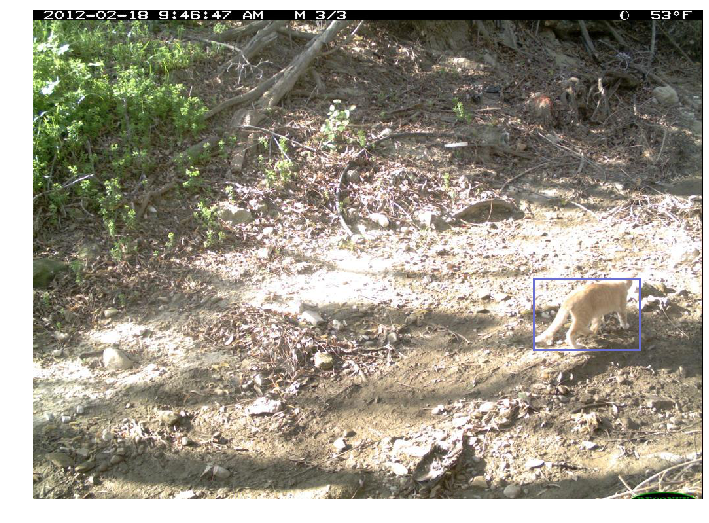

In [24]:
#!python -W ignore::DeprecationWarning
detections = detect_image(imgss[1134][0])
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(imgss[1134][0])
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        
plt.axis('off')

plt.show()

In [25]:
#!python -W ignore::DeprecationWarning
from PIL import Image
detections = detect_image(imgss[1134][0])
img = np.array(imgss[1134][0])
pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
imgs = imgss[1134][0]
#x = x1
#y = y1-box_h
#x+w = x1+box_w
#y+h = y1
box_h = box_h.item()
box_w = box_w.item()
y1 = y1.item()
x1 = x1.item()

region = imgs.crop((x1, y1, x1+box_w, y1+box_h))
print(region)

<PIL.Image.Image image mode=RGB size=162x109 at 0x7FF53F3F2DD8>


In [26]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import scipy.misc
import zipfile

%matplotlib inline 



In [27]:
'''
from PIL import Image
#!python -W ignore::DeprecationWarning
startdir = "p_train_set"  #要压缩的文件夹路径
file_news = startdir +'.zip' # 压缩后文件夹的名字
azip = zipfile.ZipFile(file_news, 'w')
for i in range(len(imgss)):
    detections = detect_image(imgss[i][0])
    #cmap = plt.get_cmap('tab20b')
    #colors = [cmap(i) for i in np.linspace(0, 1, 20)]
    img = np.array(imgss[i][0])
    #plt.figure()
    #fig, ax = plt.subplots(1, figsize=(12,9))
    #ax.imshow(img)

    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x

    if detections is not None:
        #unique_labels = detections[:, -1].cpu().unique()
        #n_cls_preds = len(unique_labels)
        #bbox_colors = random.sample(colors, n_cls_preds)
        # browse detections and draw bounding boxes
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            box_h = ((y2 - y1) / unpad_h) * img.shape[0]
            box_w = ((x2 - x1) / unpad_w) * img.shape[1]
            y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
            x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
            #color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            #bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
            #ax.add_patch(bbox)
            
        box_h = box_h.item()
        box_w = box_w.item()
        y1 = y1.item()
        x1 = x1.item()

        region = imgss[i][0].crop((x1, y1, x1+box_w, y1+box_h))
        
        imgname = imgss[i][2]
        scipy.misc.imsave(imgname, region)
        azip.write(imgname, compress_type=zipfile.ZIP_LZMA)
        #train_list.append(imgname)
        #for filename in os.listdir('/kaggle/working'):
        #if filename.endswith('.jpg'):
        os.remove(imgname)
azip.close()
#plt.axis('off')

#plt.show()

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-27-afe06c9f74a3>, line 52)